<a href="https://colab.research.google.com/github/ozwin/Snake_Species_Recognition/blob/main/Models/ResNet34/ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

In [5]:
training_path = '/content/5-class/preprocessed-cleaned-set/train/'
test_path = '/content/5-class/preprocessed-cleaned-set/test'
val_path = '/content/5-class/preprocessed-cleaned-set/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)

    mean, std = get_mean_std(train_Loader)

    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)


    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

def show_transformed_images(data_loader_train):
    batch=next(iter(data_loader_train))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    print("labels:",labels)

In [6]:
train_loader,test_loader,val_loader = transformDS1(32,224)

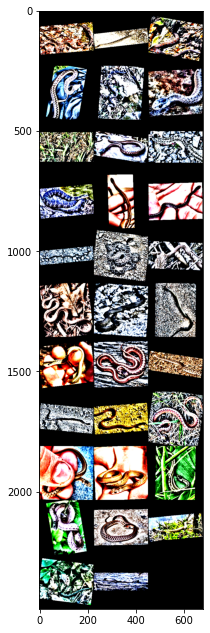

labels: tensor([1, 4, 0, 1, 0, 2, 1, 2, 2, 0, 2, 2, 1, 4, 0, 2, 0, 1, 1, 2, 4, 0, 2, 2,
        2, 2, 2, 2, 1, 0, 0, 0])


In [7]:
show_transformed_images(train_loader)

In [8]:
import torch.cuda


def set_device():
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"
    return device

In [17]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    device = set_device()
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [28]:
resnet_34 = models.resnet34(pretrained=False)
num_classes = 5
device = set_device()
num_filters = resnet_34.fc.in_features
resnet_34.fc = nn.Linear(num_filters, num_classes)
resnet_34 = resnet_34.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_34.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
n_epochs = 10

In [ ]:

Accuracies = [] 
testAccuracies = []
total_steps = len(train_loader)
t1 = time.time()
for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch+1))
    resnet_34.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    device = set_device()
    for i, data in enumerate(train_loader):
        images,labels = data
        images = images.to(device)
        labels = labels.to(device)
        total+=labels.size(0)

        optimizer.zero_grad()
        outputs = resnet_34(images)
        _,predicted = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct += (labels==predicted).sum().item()
        if (i + 1) % 100 == 0:
          validation_accuracy = 0
          resnet_34.eval()
          with torch.no_grad(): 
              val_correct = 0
              val_total = 0
              for data in val_loader:
                  images, val_labels = data[0].to(device), data[1].to(device)
                  outputs = resnet_34(images)
                  # Validation set accuracy
                  val_total = val_labels.size(0)
                  _,predicted = torch.max(outputs.data, 1)
                  val_correct += (predicted == val_labels).sum().item()
                  val_total  += val_labels.size(0)

          validation_accuracy = (val_correct / val_total)
          training_accuracy = (running_correct / total) * 100
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
              .format(epoch + 1, n_epochs, i + 1, total_steps, loss.item(), training_accuracy , validation_accuracy))
      

    epoch_loss = running_loss/len(train_loader)
    epoch_accuracy = 100.00 * running_correct/total
    Accuracies.append(epoch_accuracy)
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f"%(epoch_loss,epoch_accuracy))
    test_acc = evaluate_model(resnet_34,test_loader)
    testAccuracies.append(test_acc)
print("---Training has been completed----")
torch.save(resnet_34.state_dict(), "/content/5-epoch-output.pt")


Epoch number 1
Epoch [1/10], Step [100/381], Loss: 1.5760, Training Accuracy: 22.78%, Validation Accuracy: 21.43%
Epoch [1/10], Step [200/381], Loss: 1.6447, Training Accuracy: 23.62%, Validation Accuracy: 22.00%
Epoch [1/10], Step [300/381], Loss: 1.5412, Training Accuracy: 24.72%, Validation Accuracy: 25.52%
Training Data: Epoch Loss: 1.585, Epoch Accuracy: 25.614
Testing Data: Epoch Accuracy: 31.537
Epoch number 2
Epoch [2/10], Step [100/381], Loss: 1.5999, Training Accuracy: 29.50%, Validation Accuracy: 28.20%
Epoch [2/10], Step [200/381], Loss: 1.4581, Training Accuracy: 30.55%, Validation Accuracy: 26.95%
Epoch [2/10], Step [300/381], Loss: 1.7229, Training Accuracy: 30.67%, Validation Accuracy: 26.88%
Training Data: Epoch Loss: 1.533, Epoch Accuracy: 30.956
Testing Data: Epoch Accuracy: 31.938
Epoch number 3
Epoch [3/10], Step [100/381], Loss: 1.5460, Training Accuracy: 31.97%, Validation Accuracy: 29.10%
Epoch [3/10], Step [200/381], Loss: 1.5066, Training Accuracy: 31.33%, Val

In [ ]:
# Plotting Accuracies Vs Epochs
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

In [ ]:
# Plotting Test Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),testAccuracies, label="Test")
plt.xlable("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Test Accuracies")
plt.legend()
plt.show()


In [ ]:
#Calculate metrics 
